# Machine Learning Model for the InsuranceCharges Data

Let's create a Regression Machine Learning Model to predict the costs incured by a new customer with attributes (age, sex, bmi, children, smoker, region)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
#For connecting with SQL database
import pymssql
from config import database
from config import username
from config import password
from config import server

In [2]:
#Create connectiong to databse
conn = pymssql.connect(server, username, password, database)
cursor = conn.cursor()

In [3]:
#Run the query to gather the table
table = 'dbo.InsuranceCharges'

querycosts = '''Select I.ChargeID, I.ChargeValue, I.AgeID, A.AgeLabel, I.ChildrenID, C.ChildrenLabel, I.RegionID, 
R.RegionLabel, I.SexID, S.SexLabel, I.SmokerID, Sm.SmokerLabel, I.BMI from InsuranceCharges I
inner join Age A on I.AgeID = A.AgeID
inner join Children C on  I.ChildrenID = C.ChildrenID
inner join Region R on  I.RegionID = R.RegionID
inner join Sex S on  I.SexID = S.SexID
inner join Smoker Sm on  I.SmokerID = Sm.SmokerID
'''


In [4]:
#Load the query to a pandas dataframe
df_costs = pd.read_sql(querycosts, conn)

C:\Users\Christian\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [5]:
df_costs

,ChargeID,ChargeValue,AgeID,AgeLabel,ChildrenID,ChildrenLabel,RegionID,RegionLabel,SexID,SexLabel,SmokerID,SmokerLabel,BMI
0,1,11082.577,38,55,1,0,1,northwest,1,female,1,False,26.980
1,2,14711.744,3,20,1,0,1,northwest,1,female,2,True,22.420
2,3,1743.214,2,19,1,0,4,southwest,1,female,1,False,28.900
3,4,8516.829,28,45,3,2,2,southeast,1,female,1,False,28.600
4,5,12268.632,38,55,3,2,1,northwest,1,female,1,False,32.775
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,1334,37484.449,5,22,3,2,2,southeast,2,male,2,True,37.070
1334,1335,4462.722,15,32,2,1,1,northwest,2,male,1,False,33.820
1335,1336,48970.248,42,59,2,1,2,southeast,2,male,2,True,41.140
1336,1337,19673.336,11,28,1,0,1,northwest,2,male,1,False,33.820


In [6]:
df = df_costs[['AgeLabel', 'SexLabel', 'BMI', 'ChildrenLabel', 'RegionLabel', 'ChargeValue', 'SmokerLabel']]
df

,AgeLabel,SexLabel,BMI,ChildrenLabel,RegionLabel,ChargeValue,SmokerLabel
0,55,female,26.980,0,northwest,11082.577,False
1,20,female,22.420,0,northwest,14711.744,True
2,19,female,28.900,0,southwest,1743.214,False
3,45,female,28.600,2,southeast,8516.829,False
4,55,female,32.775,2,northwest,12268.632,False
...,...,...,...,...,...,...,...
1333,22,male,37.070,2,southeast,37484.449,True
1334,32,male,33.820,1,northwest,4462.722,False
1335,59,male,41.140,1,southeast,48970.248,True
1336,28,male,33.820,0,northwest,19673.336,False


In [7]:
#Make sure all columns are numerical in order to feed them into the ML model
df = df.astype({"AgeLabel": int, "ChildrenLabel": int})

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   AgeLabel       1338 non-null   int32  
 1   SexLabel       1338 non-null   object 
 2   BMI            1338 non-null   float64
 3   ChildrenLabel  1338 non-null   int32  
 4   RegionLabel    1338 non-null   object 
 5   ChargeValue    1338 non-null   float64
 6   SmokerLabel    1338 non-null   bool   
dtypes: bool(1), float64(2), int32(2), object(2)
memory usage: 53.7+ KB


In [9]:
#df.to_csv('database_insurance.csv', header=True, index=False)

Make dummy variables for region and sex

In [10]:
df_dummies = pd.get_dummies(df, columns = ['SexLabel', 'RegionLabel', 'SmokerLabel'], drop_first = True)

In [11]:
df_dummies.describe()

,AgeLabel,BMI,ChildrenLabel,ChargeValue,SexLabel_male,RegionLabel_northwest,RegionLabel_southeast,RegionLabel_southwest,SmokerLabel_True
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422294,0.505232,0.242900,0.272048,0.242900,0.204783
std,14.049960,6.098187,1.205493,12110.011230,0.500160,0.428995,0.445181,0.428995,0.403694
min,18.000000,15.960000,0.000000,1121.874000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,26.296250,0.000000,4740.287000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,39.000000,30.400000,1.000000,9382.033000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,51.000000,34.693750,2.000000,16639.912250,1.000000,0.000000,1.000000,0.000000,0.000000
max,64.000000,53.130000,5.000000,63770.428000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
X = df_dummies.drop(columns = 'ChargeValue').copy()
y = df_dummies[['ChargeValue']].copy()

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 9)

In [14]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

Let's assess how our model is doing compared to the test set

In [15]:
charge_predictions = model.predict(X_test)

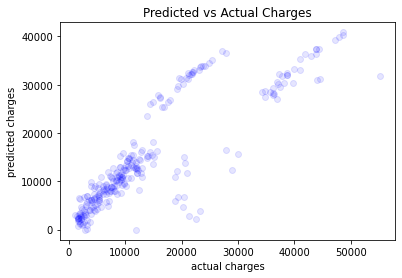

In [16]:
# Plot outputs
plt.scatter(y_test, charge_predictions, color="blue", alpha=0.1)

#plt.plot(diabetes_X_test, diabetes_y_pred, color="blue", linewidth=3)
plt.xlabel('actual charges')
plt.ylabel('predicted charges')
plt.title('Predicted vs Actual Charges')

plt.show()

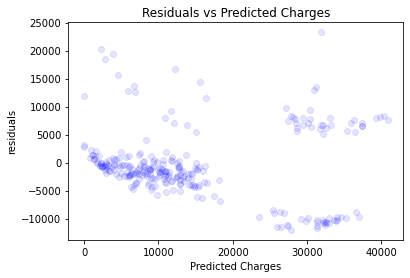

In [17]:
# Plot residuals
residuals = y_test - charge_predictions
plt.scatter(charge_predictions, residuals, color="blue", alpha=0.1)
plt.xlabel('Predicted Charges')
plt.ylabel('residuals')
plt.title('Residuals vs Predicted Charges')

plt.show()

In [18]:
model.score(X_test, y_test)

0.7471902327025666

Let's check how our model does when we eliminate the `SexLabel` column

In [19]:
df_dummies

,AgeLabel,BMI,ChildrenLabel,ChargeValue,SexLabel_male,RegionLabel_northwest,RegionLabel_southeast,RegionLabel_southwest,SmokerLabel_True
0,55,26.980,0,11082.577,0,1,0,0,0
1,20,22.420,0,14711.744,0,1,0,0,1
2,19,28.900,0,1743.214,0,0,0,1,0
3,45,28.600,2,8516.829,0,0,1,0,0
4,55,32.775,2,12268.632,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...
1333,22,37.070,2,37484.449,1,0,1,0,1
1334,32,33.820,1,4462.722,1,1,0,0,0
1335,59,41.140,1,48970.248,1,0,1,0,1
1336,28,33.820,0,19673.336,1,1,0,0,0


In [20]:
no_sex_df = df_dummies.copy()

In [21]:
no_sex_df = no_sex_df.drop(columns = 'SexLabel_male')

In [22]:
no_sex_df

,AgeLabel,BMI,ChildrenLabel,ChargeValue,RegionLabel_northwest,RegionLabel_southeast,RegionLabel_southwest,SmokerLabel_True
0,55,26.980,0,11082.577,1,0,0,0
1,20,22.420,0,14711.744,1,0,0,1
2,19,28.900,0,1743.214,0,0,1,0
3,45,28.600,2,8516.829,0,1,0,0
4,55,32.775,2,12268.632,1,0,0,0
...,...,...,...,...,...,...,...,...
1333,22,37.070,2,37484.449,0,1,0,1
1334,32,33.820,1,4462.722,1,0,0,0
1335,59,41.140,1,48970.248,0,1,0,1
1336,28,33.820,0,19673.336,1,0,0,0


In [23]:
no_sex_X = no_sex_df.drop(columns = 'ChargeValue').copy()
no_sex_y = no_sex_df['ChargeValue'].copy()

In [24]:
no_sex_X_train, no_sex_X_test, no_sex_y_train, no_sex_y_test = train_test_split(no_sex_X, no_sex_y, test_size=0.20, random_state = 9)

In [25]:
no_sex_model = LinearRegression()
no_sex_model.fit(no_sex_X_train, no_sex_y_train)

LinearRegression()

Let's see how this model performs compared to the other

In [26]:
no_sex_charge_predictions = no_sex_model.predict(no_sex_X_test)

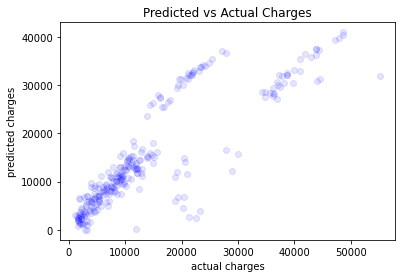

In [27]:
# Plot outputs
plt.scatter(no_sex_y_test, no_sex_charge_predictions, color="blue", alpha=0.1)

#plt.plot(diabetes_X_test, diabetes_y_pred, color="blue", linewidth=3)
plt.xlabel('actual charges')
plt.ylabel('predicted charges')
plt.title('Predicted vs Actual Charges')

plt.show()

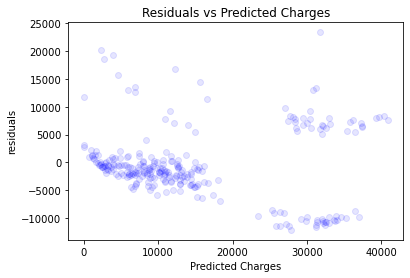

In [28]:
# Plot residuals
no_sex_residuals = no_sex_y_test - no_sex_charge_predictions
plt.scatter(no_sex_charge_predictions, no_sex_residuals, color="blue", alpha=0.1)
plt.xlabel('Predicted Charges')
plt.ylabel('residuals')
plt.title('Residuals vs Predicted Charges')

plt.show()

In [29]:
no_sex_model.score(no_sex_X_test, no_sex_y_test)

0.7471799707582683

Seeing how the model performs the same with and without sex, we will use the data without the sex column

Let's try to optimize the model

In [30]:
clf = Lasso(alpha=0.1)

In [31]:
clf.fit(no_sex_X_train, no_sex_y_train)

Lasso(alpha=0.1)

In [32]:
print(clf.coef_)

[  271.59469028   301.38035071   424.54124105  -657.72219066
  -995.54980931  -985.07983053 23993.24596818]


In [33]:
clf.score(no_sex_X_test, no_sex_y_test)

0.7471827057656257

In [34]:
reg = LassoCV(cv=5, random_state=9).fit(no_sex_X_train, no_sex_y_train)

In [35]:
reg.score(no_sex_X_test, no_sex_y_test)

0.7472607952218686

In [36]:
lasso = Lasso(random_state=9)
alphas = np.logspace(-3, 3, 800)

tuned_parameters = [{"alpha": alphas}]
n_folds = 5

clf = GridSearchCV(lasso, tuned_parameters, cv=n_folds, refit=False)
clf.fit(no_sex_X_train, no_sex_y_train)
scores = clf.cv_results_["mean_test_score"]
scores_std = clf.cv_results_["std_test_score"]

(0.001, 1000.0)

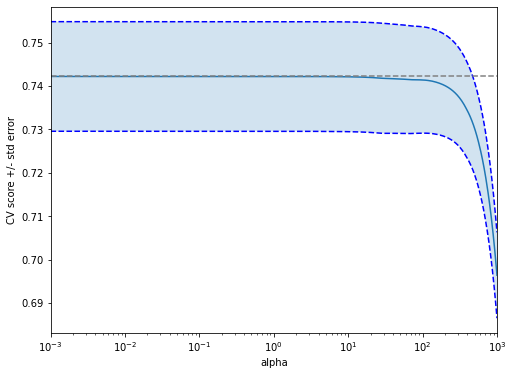

In [37]:
plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, "b--")
plt.semilogx(alphas, scores - std_error, "b--")

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel("CV score +/- std error")
plt.xlabel("alpha")
plt.axhline(np.max(scores), linestyle="--", color=".5")
plt.xlim([alphas[0], alphas[-1]])

We can see from the plot above that the score is relatively flat and starts to decrease at $\alpha$ ~ 100.
An $\alpha$ = 0 is simply a LinearRegression. Let's see how else we can improve the accuracy of the model in the next notebook `ML-DBmodel2.ipynb`